## Part III: Predicting missing build years



This part of the project shows the process of developing a model to predict the missing values of construction years

### Preprocessing

In [4]:
# importing libraries
import joblib, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    PassiveAggressiveRegressor,
    HuberRegressor,
    TweedieRegressor,
    BayesianRidge,
    OrthogonalMatchingPursuit
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    IsolationForest,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from lazypredict.Supervised import LazyClassifier

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

import plotly.express as px
import plotly.graph_objects as go

from typing import List

from modules.analytical_tools import regressor_models_comparison

In [11]:
df = pd.read_csv('data/wroclaw_dataset_ver_2.csv')
df.shape

(9016, 141)

In [83]:
df.head()

,PRICE,AREA,BUILD_YEAR,BUILDING_FLOORS_NUM,PRICE_PER_M2,DISTANCE_FROM_CITY_CENTER_KM,SECURITY_TYPES_0,SECURITY_TYPES_alarm,SECURITY_TYPES_anti_burglary_door,SECURITY_TYPES_closed_area,...,RESIDENTIAL_AREA_Widawa,RESIDENTIAL_AREA_Wojszyce,RESIDENTIAL_AREA_Zacisze-Zalesie-Szczytniki,RESIDENTIAL_AREA_Świniary,RESIDENTIAL_AREA_Żerniki,DISTRICT_Fabryczna,DISTRICT_Krzyki,DISTRICT_Psie Pole,DISTRICT_Stare Miasto,DISTRICT_Śródmieście
0,800000.00,69.00,1930.00,2.00,11594.20,4.25,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,427699.00,39.12,2023.00,2.00,10933.00,4.46,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,494494.00,47.32,2023.00,4.00,10450.00,4.46,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,884400.00,66.00,2013.00,3.00,13400.00,3.97,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,379464.00,56.54,2023.00,4.00,6711.43,5.30,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [84]:
df = df.dropna()

In [85]:
df.shape

(7798, 141)

### Checking strenght of correlations with BUILD_YEAR

Absolute value of correlation is measured on a 0.1 to 1.0 scale. <br>
* weak correlation would be in the range of 0.1 to 0.3
* moderate correlation from 0.3 to 0.5, 
* strong  correlation from 0.5 to 0.7.
* very strong correlation is higert than 0.7

In [86]:
def correlations_intervals(df: pd.DataFrame, column_name: str):
    """Prints the number of correlations within each interval strength."""

    # generating correlation plot
    corr = df.corr()
    # selecting only the specified column and sorting the absolute values of the correlations in descending order
    corr_with_column = corr[column_name].sort_values(key=lambda x: abs(x), ascending=False)
    
    # defining interval strengths and their corresponding labels
    interval_strength = {0.0: 'weak / no correlation', 0.3: 'moderate', 0.5: 'strong', 0.7: 'very strong'}
    interval_ranges = {0.0: '0.0 - 0.3', 0.3: '0.3 - 0.5', 0.5: '0.5 - 0.7', 0.7: '0.7 - 1.0'}
   
    # counting correlations within each interval strength
    for threshold, strength in interval_strength.items():
        count = ((corr_with_column.abs() >= threshold) & (corr_with_column.abs() < threshold+0.2)).sum()
        interval_range = interval_ranges[threshold]
        print(f"Number of correlations with {strength} strength ({interval_range}): {count}")
    return corr_with_column

corr_df = correlations_intervals(df, 'BUILD_YEAR')

Number of correlations with weak / no correlation strength (0.0 - 0.3): 116
Number of correlations with moderate strength (0.3 - 0.5): 6
Number of correlations with strong strength (0.5 - 0.7): 5
Number of correlations with very strong strength (0.7 - 1.0): 1


There is 12 parameters with more than weak correlation

In [87]:
# generating correlation matrix
corr = df.corr()

# selecting only the BUILD_YEAR column and sorting the absolute values of the correlations in descending order
corr_with_price = corr['BUILD_YEAR'].sort_values(key=lambda x: abs(x), ascending=False)

# creating a column with the absolute value of the correlation
corr_abs = abs(corr_with_price)

# creating a DataFrame with a correlation value and its absolute value
corr_df = pd.DataFrame({'Correlation': corr_with_price, 'Absolute Correlation': corr_abs})

# showing only parameters with significant correlation
corr_df[corr_df['Absolute Correlation'] >= 0.3]

,Correlation,Absolute Correlation
BUILD_YEAR,1.00,1.00
BUILDING_TYPE_tenement,-0.73,0.73
MARKET_TYPE_secondary,-0.63,0.63
MARKET_TYPE_primary,0.63,0.63
EXTRAS_TYPES_basement,-0.56,0.56
BUILDING_MATERIAL_brick,-0.54,0.54
EXTRAS_TYPES_lift,0.52,0.52
EXTRAS_TYPES_garage,0.48,0.48
CONSTRUCTION_STATUS_to_completion,0.47,0.47
HEATING_gas,-0.37,0.37


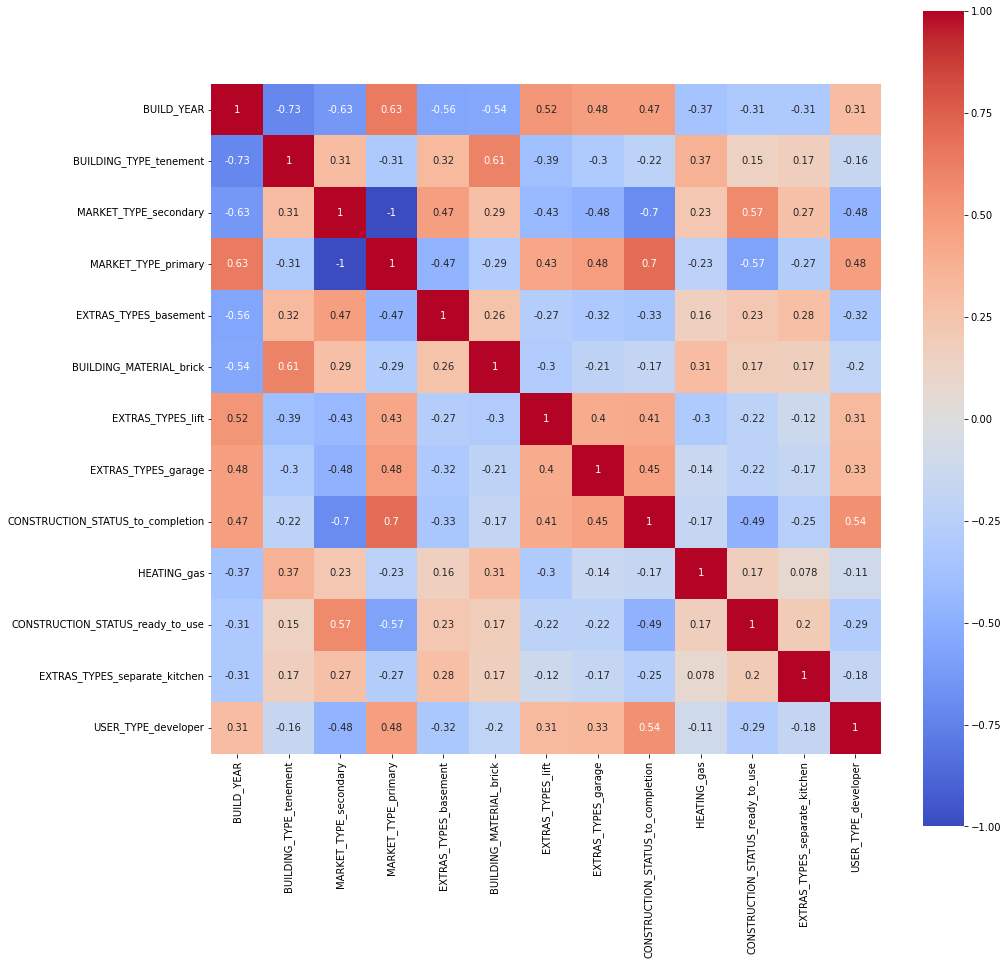

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()

# creating a DataFrame with a correlation value and its absolute value
corr_with_price = corr['BUILD_YEAR'].sort_values(key=lambda x: abs(x), ascending=False)
corr_abs = abs(corr_with_price)
corr_df = pd.DataFrame({'Correlation': corr_with_price, 'Absolute Correlation': corr_abs})

# selection of columns with an absolute value of correlation above 0.3
strong_corr = corr_df[corr_df['Absolute Correlation'] > 0.3]
strong_corr_columns = strong_corr.index.tolist()
df_filtered = df[strong_corr_columns]

plt.figure(figsize=(15,15))
# heatmap generation for selected columns
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', square=1)


plt.show()

### Building model to predict values

In [89]:
# splitting dataset to data and target

X = df.drop(columns=['BUILD_YEAR'])
y = df['BUILD_YEAR']

In [90]:
# splitting data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [91]:
# creating list of models to compare
models = [
    LinearRegression(),
    Ridge(alpha=0.1),
    Lasso(alpha=0.1),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    DecisionTreeRegressor(), 
    XGBRegressor(), 
    GradientBoostingRegressor(),
    AdaBoostRegressor(), 
    RandomForestRegressor(), 
    KNeighborsRegressor(n_neighbors=5),
    SVR(),
    MLPRegressor(),
    BayesianRidge(),
    PassiveAggressiveRegressor(),
    HuberRegressor(),
    TweedieRegressor(),
    GaussianProcessRegressor(),
    OrthogonalMatchingPursuit(),
    CatBoostRegressor(verbose=0),
    LGBMRegressor()
]

warnings.filterwarnings("ignore",)


results = regressor_models_comparison(X_train, X_test, y_train, y_test, models, verbose= True, round_prediction=0)

Successfully evaluated ( 1 / 20) : LinearRegression           -> MAE:   8.01, R2: 0.83
Successfully evaluated ( 2 / 20) : Ridge                      -> MAE:   8.01, R2: 0.83
Successfully evaluated ( 3 / 20) : Lasso                      -> MAE:   8.29, R2: 0.82
Successfully evaluated ( 4 / 20) : ElasticNet                 -> MAE:   9.04, R2: 0.81
Successfully evaluated ( 5 / 20) : DecisionTreeRegressor      -> MAE:   5.11, R2: 0.81
Successfully evaluated ( 6 / 20) : XGBRegressor               -> MAE:   4.93, R2: 0.88
Successfully evaluated ( 7 / 20) : GradientBoostingRegressor  -> MAE:   5.46, R2: 0.87
Successfully evaluated ( 8 / 20) : AdaBoostRegressor          -> MAE:  10.07, R2: 0.75
Successfully evaluated ( 9 / 20) : RandomForestRegressor      -> MAE:   3.96, R2: 0.91
Successfully evaluated (10 / 20) : KNeighborsRegressor        -> MAE:  17.61, R2: 0.15
Successfully evaluated (11 / 20) : SVR                        -> MAE:  17.09, R2: -0.27
Successfully evaluated (12 / 20) : MLPRegr

In [92]:
# creating pivot table to check mean values of each model and metrics

results_pivot_table = pd.pivot_table(results, index='Model',
                             values=['MSE', 'RMSE', 'MAE', 'R2'],
                             aggfunc=np.mean)

results_pivot_table = results_pivot_table.sort_values('R2', ascending=False)
results_pivot_table

,MAE,MSE,R2,RMSE
Model,,,,
RandomForestRegressor,3.96,88.75,0.91,9.42
LGBMRegressor,4.47,90.97,0.90,9.54
CatBoostRegressor,4.64,96.68,0.90,9.83
XGBRegressor,4.93,109.71,0.88,10.47
GradientBoostingRegressor,5.46,122.50,0.87,11.07
BayesianRidge,7.97,156.11,0.83,12.49
Ridge,8.01,158.76,0.83,12.60
LinearRegression,8.01,158.99,0.83,12.61
Lasso,8.29,168.76,0.82,12.99


The metrics suggest that the models with the best quality are:<b>
* RandomForestRegressor 
* LGBMRegressor 
* CatBoostRegressor
* XGBRegressor 
</b>

R2 values oscillate around the value of 0.9, which means a very accurate fit to the data

Next, it will be checked how removing outliers and standardization will affect the metrics

### Removing outliers from continous columns

In [93]:
# preparing list of continuous columns

continuous_cols = []
for col in X.columns:
    if set(X[col].unique()) != {0, 1}:
        continuous_cols.append(col)


In [94]:
total_num_of_outliers = 0

df_clean = df.copy()

for column in continuous_cols:

    start_num_samples = df_clean.shape[0]
    
    # removing outliers with IQR method

    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1

    df_clean = df_clean[(df_clean[column] > (Q1 - 3 * IQR)) & (df_clean[column] < (Q3 + 3 * IQR))]


    num_removed = start_num_samples - df_clean.shape[0]
    total_num_of_outliers += num_removed
  
    print(f'Removed {num_removed} samples from column: {column}')


print(f'\nRemoved {total_num_of_outliers} outliers')
print(f"Number of remaining samples: {df_clean.shape[0]}")

Removed 56 samples from column: PRICE
Removed 27 samples from column: AREA
Removed 128 samples from column: BUILDING_FLOORS_NUM
Removed 0 samples from column: PRICE_PER_M2
Removed 0 samples from column: DISTANCE_FROM_CITY_CENTER_KM

Removed 211 outliers
Number of remaining samples: 7587


Repeat the previous steps to compare the results with cleaned data

In [95]:
# splitting dataset to data and target

X = df_clean.drop(columns=['BUILD_YEAR'])
y = df_clean['BUILD_YEAR']

# splitting data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:

# scaling continuous columns
scaler = StandardScaler()

# Fit scaler only on training data
scaler.fit(X_train[continuous_cols])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_cols] = scaler.transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])


In [97]:
# evaluating models
clean_scaled_results = regressor_models_comparison(X_train_scaled, X_test_scaled, y_train, y_test, models, verbose= True, round_prediction=0)

Successfully evaluated ( 1 / 20) : LinearRegression           -> MAE: 225821332.03, R2: -80823449979084864.00
Successfully evaluated ( 2 / 20) : Ridge                      -> MAE:   8.05, R2: 0.84
Successfully evaluated ( 3 / 20) : Lasso                      -> MAE:   8.29, R2: 0.83
Successfully evaluated ( 4 / 20) : ElasticNet                 -> MAE:   9.18, R2: 0.81
Successfully evaluated ( 5 / 20) : DecisionTreeRegressor      -> MAE:   4.84, R2: 0.85
Successfully evaluated ( 6 / 20) : XGBRegressor               -> MAE:   4.85, R2: 0.89
Successfully evaluated ( 7 / 20) : GradientBoostingRegressor  -> MAE:   5.28, R2: 0.89
Successfully evaluated ( 8 / 20) : AdaBoostRegressor          -> MAE:  18.58, R2: 0.55
Successfully evaluated ( 9 / 20) : RandomForestRegressor      -> MAE:   3.78, R2: 0.93
Successfully evaluated (10 / 20) : KNeighborsRegressor        -> MAE:   4.65, R2: 0.88
Successfully evaluated (11 / 20) : SVR                        -> MAE:   7.53, R2: 0.74
Successfully evaluat

### Results analysis

In [98]:
# creating pivot table to check scaled metrics 

clean_scaled_results_pivot_table = pd.pivot_table(clean_scaled_results, index='Model',
                             values=['MSE', 'RMSE', 'MAE', 'R2'],
                             aggfunc=np.mean)


clean_scaled_results_pivot_table = clean_scaled_results_pivot_table.sort_values('R2', ascending=False)


In [99]:
# creating pivot tables to check comparison
results_combinded = pd.concat([results_pivot_table, clean_scaled_results_pivot_table.add_prefix('new_')], axis=1)

# modyfiing and adding values
results_combinded = results_combinded.rename(columns={'MAE': 'old_MAE' , 'R2': 'old_R2'} )
# results_combinded = results_combinded.rename(columns={'MAE': 'MAE_old', 'R2': 'old_R2'})

results_combinded['diff_MAE'] =  results_combinded['new_MAE'] - results_combinded['old_MAE']
results_combinded['diff_R2'] =  results_combinded['new_R2'] - results_combinded['old_R2']

results_combinded = results_combinded[["old_MAE", "new_MAE",'diff_MAE',  "old_R2", "new_R2", "diff_R2"]]
results_combinded.sort_values('new_MAE', ascending=1)

,old_MAE,new_MAE,diff_MAE,old_R2,new_R2,diff_R2
Model,,,,,,
RandomForestRegressor,3.96,3.78,-0.18,0.91,0.93,0.02
LGBMRegressor,4.47,4.31,-0.16,0.90,0.92,0.01
CatBoostRegressor,4.64,4.48,-0.16,0.90,0.92,0.02
KNeighborsRegressor,17.61,4.65,-12.96,0.15,0.88,0.73
DecisionTreeRegressor,5.11,4.84,-0.27,0.81,0.85,0.04
XGBRegressor,4.93,4.85,-0.08,0.88,0.89,0.01
GradientBoostingRegressor,5.46,5.28,-0.18,0.87,0.89,0.02
HuberRegressor,90.79,7.44,-83.35,-31.35,0.74,32.09
SVR,17.09,7.53,-9.56,-0.27,0.74,1.01


Removing outliers and standarisation improved results of almost every regression model<br><br>
Previosly the best models:
* RandomForestRegressor 
* LGBMRegressor 
* CatBoostRegressor
* XGBRegressor 

<b>The metrics of the best models have improved even more compared to the previous version of data</b>

<b>KNeighborsRegressor: </b> works much better, new value of R2 and MAE are simmilar to the rest of top models

some of the other models that worked poorly before modyfing dataset are on the satisfing level now, but they they do not qualify for the best results

Theres obvious problem with standard LinearRegression, which is clearly not able to predict basing on the changed data, hovewer metrics in the first comparison also wasn't satisfying  <br>


### Visual comparison of the best models 

In [100]:
warnings.filterwarnings("ignore",)
# znalezc najlepsze hiperaramety i zrobic porownanie plotyl top 5 modeli
best_models = [
    CatBoostRegressor(verbose=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=0.1, learning_rate=0.01, od_wait=10),
    RandomForestRegressor(max_depth= None, max_features='auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100),
    LGBMRegressor(learning_rate= 0.01, max_depth=8, min_child_samples= 1, n_estimators= 1000, num_leaves= 63, reg_alpha=0.5, reg_lambda= 0.1),
]

clean_scaled_results = regressor_models_comparison(X_train_scaled, X_test_scaled, y_train, y_test, best_models, verbose= True, visualize_fit= False, visualize_resid= True, round_prediction=0)

Successfully evaluated ( 1 / 3) : CatBoostRegressor     -> MAE:   4.26, R2: 0.92
Successfully evaluated ( 2 / 3) : RandomForestRegressor -> MAE:   3.71, R2: 0.93
Successfully evaluated ( 3 / 3) : LGBMRegressor         -> MAE:   3.92, R2: 0.93


Conclusions from visualisation:<br>
* Random Forest Regressor has the least tendencies to overestimate true values for buildngs built after 2000 year
* Diffrences between true and predicted values before year 2000 are simmilar in all models 
* It seems that people who posted offers probably rounded uncertain dates to round years,
* It's noticable especially on years: 1900, 1910, 1930, 1970. 
* Algorithms tried to find data based on correlations, but they were unable to predict significant rounding by retailers
<br><br>

The most important conclusion is that <b>all of the models cope much worse with older dates.</b> This may result from too inaccurately entered data or dependencies that regression models cannot detect <br><br>
Now a neural network will be built to see if it can handle the data

### Neutral Network

In [101]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

nn_model = Sequential()

nn_model.add(Dense(64, activation='relu', kernel_regularizer='l2', input_shape=(len(X.keys()),)))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

opt = optimizers.Adam(learning_rate=0.001)

nn_model.compile(optimizer=opt, loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

checkpoint = ModelCheckpoint('build_year_best_model_nn.h5', monitor='val_loss', save_best_only=True, mode='min')

nn_model_history = nn_model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stop, checkpoint])


Epoch 1/500
190/190 [==============================] - 1s 3ms/step - loss: 3800032.5000 - mae: 1947.9928 - val_loss: 3095141.7500 - val_mae: 1759.0126
Epoch 2/500
190/190 [==============================] - 0s 2ms/step - loss: 1422580.0000 - mae: 1106.0884 - val_loss: 133856.2344 - val_mae: 337.7371
Epoch 3/500
190/190 [==============================] - 0s 2ms/step - loss: 42714.5391 - mae: 163.9302 - val_loss: 25493.5293 - val_mae: 122.9504
Epoch 4/500
190/190 [==============================] - 0s 2ms/step - loss: 22201.4980 - mae: 114.5883 - val_loss: 17722.3984 - val_mae: 105.0746
Epoch 5/500
190/190 [==============================] - 0s 2ms/step - loss: 15542.5791 - mae: 97.0579 - val_loss: 12553.1660 - val_mae: 89.0570
Epoch 6/500
190/190 [==============================] - 0s 2ms/step - loss: 11113.1084 - mae: 82.2372 - val_loss: 9154.9219 - val_mae: 75.6730
Epoch 7/500
190/190 [==============================] - 0s 2ms/step - loss: 8175.5552 - mae: 70.2442 - val_loss: 6913.6685 - v

In [102]:
# predicting values 
y_pred = nn_model.predict(X_test_scaled)
y_pred = np.round(y_pred)

y_pred[y_pred > 2025] = 2025

# calculating metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# show metrics
print("R2: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))

# #create residual plot
residuals = y_test - y_pred.flatten()

nn_fig = px.scatter(x=y_pred.flatten(), y=residuals, labels={'x':'y_pred', 'y':'residual'})

nn_fig.add_shape(type='line',
              x0=y_pred.flatten().min(), x1=y_pred.flatten().max(),
              y0=0, y1=0,
              line=dict(color='red', width=3, dash='dash'))

nn_fig.update_traces(texttemplate='%{y:.2f}', textposition='top center', hovertemplate='Predicted build year: %{x:.2f} <br> residual: %{y:.2f}')

nn_fig.update_layout(title='Residual Plot', xaxis_title='y_pred', yaxis_title='Residual')

nn_fig.show()


R2: 0.87
MAE: 5.82


Each model, including Neutral Network is able to achive almosts satisfying results in predicting new constructions.<br>
Hovewer the older dates are much more problematic to every kind of model.

This problem will be tried to be fixed by grouping years to ranges and using classification models

### Creating classification model

Grouping years to ranges

In [103]:

y_test_cat = y_test.to_frame()
y_train_cat = y_train.to_frame()

# Obliczenie wieku każdego rekordu w latach
y_test_cat['BUILDING_AGE'] = (2023 - y_test_cat['BUILD_YEAR'])
y_train_cat['BUILDING_AGE'] = (2023 - y_train_cat['BUILD_YEAR'])


# Tworzenie kategorii wiekowych
bins = [-float('inf'), 5 , 30,  60, float('inf')]
labels = ['0-5', '6-30', '31-60', '60+']

y_test_cat['BUILDING_AGE'] = pd.cut(y_test_cat['BUILDING_AGE'], bins=bins, labels=labels)
y_train_cat['BUILDING_AGE'] = pd.cut(y_train_cat['BUILDING_AGE'], bins=bins, labels=labels)
y_train_cat


,BUILD_YEAR,BUILDING_AGE
5908,1960.00,60+
2866,2020.00,0-5
399,1980.00,31-60
8025,2023.00,0-5
383,2022.00,0-5
...,...,...
6308,2022.00,0-5
6350,2024.00,0-5
6526,2025.00,0-5
1014,1950.00,60+


In [104]:

# Searching for the best models with LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train_cat['BUILDING_AGE'], y_test_cat['BUILDING_AGE'])

# show comparison
models

100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.93,0.91,None,0.93,1.20
RandomForestClassifier,0.92,0.90,None,0.92,0.90
LinearSVC,0.91,0.89,None,0.91,3.64
CalibratedClassifierCV,0.91,0.89,None,0.91,11.73
ExtraTreesClassifier,0.91,0.89,None,0.91,0.99
LogisticRegression,0.92,0.89,None,0.92,0.61
BernoulliNB,0.89,0.89,None,0.89,0.09
RidgeClassifierCV,0.89,0.88,None,0.90,0.22
RidgeClassifier,0.89,0.88,None,0.90,0.11


In [105]:
# using Light Gradient Boosting Machine with the best scoring
clf = lgb.LGBMClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 200, num_leaves= 3)

clf.fit(X_train_scaled, y_train_cat['BUILDING_AGE'])
y_pred = clf.predict(X_test_scaled)


cm = confusion_matrix(y_test_cat['BUILDING_AGE'], y_pred)
cm_df = pd.DataFrame(cm, index=[0, 1, 2, 3], columns=[0, 1, 2, 3])


print(classification_report(y_test_cat['BUILDING_AGE'], y_pred))


              precision    recall  f1-score   support

         0-5       0.97      0.94      0.96       965
       31-60       0.85      0.87      0.86       165
        6-30       0.75      0.79      0.77       233
         60+       0.90      0.95      0.92       155

    accuracy                           0.91      1518
   macro avg       0.87      0.89      0.88      1518
weighted avg       0.92      0.91      0.91      1518



In [106]:
# creating visualisation of confusion matrix
fig = px.imshow(cm_df,
                color_continuous_scale='blues',
                color_continuous_midpoint=0.5,
                zmin=0,
                zmax=100)

fig.update_layout(title="Confusion matrix",
                  font=dict(size=18))

fig.update_xaxes(title_text="y_pred",
                 ticktext=labels,
                 tickvals=[0, 1, 2, 3])

fig.update_yaxes(title_text="y_true",
                 ticktext=labels,
                 tickvals=[0, 1, 2, 3])

fig.show()


### Statistical significance check

Merging processed data again to one dataframe

In [107]:
train_df = pd.concat([X_train, y_train_cat], axis=1)
test_df = pd.concat([X_test, y_test_cat], axis=1)
df_v2 = pd.concat([train_df, test_df], axis=0)

In [108]:
def add_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name])
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column_name, axis=1)
    return df


df_v2 = add_dummies(df_v2,['BUILDING_AGE'] )

<AxesSubplot:>

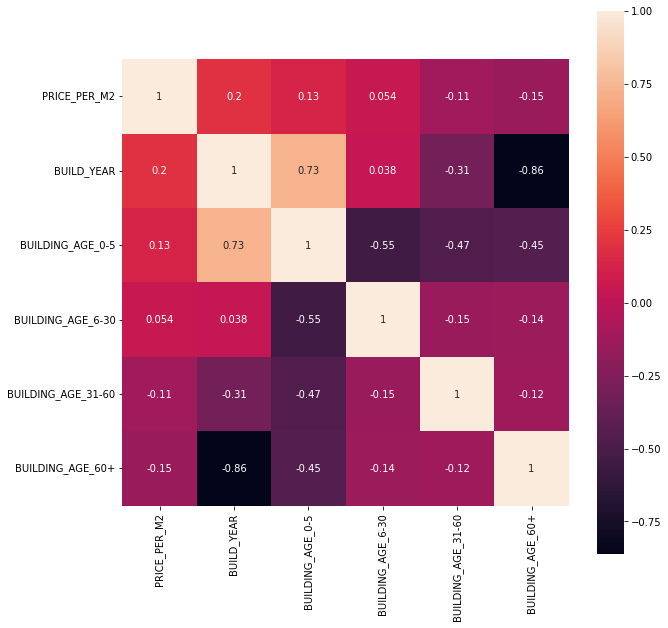

In [109]:
corr_matrix = df_v2[['PRICE_PER_M2',  'BUILD_YEAR', 'BUILDING_AGE_0-5', 'BUILDING_AGE_6-30',  'BUILDING_AGE_31-60', 'BUILDING_AGE_60+',]].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, square=True)

In [110]:
import scipy.stats as stats

corr_matrix = df_v2[['PRICE_PER_M2', 'BUILD_YEAR', 'BUILDING_AGE_0-5', 'BUILDING_AGE_6-30', 'BUILDING_AGE_31-60', 'BUILDING_AGE_60+']].corr()

p_values = []
for column in corr_matrix.columns:
    p_value = stats.pearsonr(df_v2[column], df_v2['PRICE_PER_M2'])[1]
    p_values.append(p_value)

corr_matrix.loc['p_value'] = p_values

for column in corr_matrix.columns:
    print(f"{column:20}p-value = {corr_matrix.loc['p_value', column]:.40f}")


PRICE_PER_M2        p-value = 0.0000000000000000000000000000000000000000
BUILD_YEAR          p-value = 0.0000000000000000000000000000000000000000
BUILDING_AGE_0-5    p-value = 0.0000000000000000000000000000162748149988
BUILDING_AGE_6-30   p-value = 0.0000023381945172225221484636151908498292
BUILDING_AGE_31-60  p-value = 0.0000000000000000000000482741609913887114
BUILDING_AGE_60+    p-value = 0.0000000000000000000000000000000000000110


Based on p-value and correlation matrix, it is deduced that it will be more important to keep the original column - year of build

### Conclusions


Ufortunately, based on the data available for analysis, it was not possible to create a model that would be able to reliably supplement the missing year of build.

Despite a good R2 indicator, the regression models make too large errors in the case of buildings built especially before the year 2000, often reaching around 50 years

Classification models seem to be more precise, but the generalization of data to intervals resulting from their specificity reduces the strength of correlation, which could reduce the quality of data from the column too much to accept.

Therefore, this project abandons the attempt to recover all of missing data in this parameter


However, going back to the visualization from the first part of the project, you can see that <b>most of the offers from the data set have a construction year of 2023-2025

In [111]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=df['BUILD_YEAR'], marker_color='orange', nbinsx=100, name='Build year'))

fig.update_layout(title_text="Distribution of build year",
                  xaxis=dict(title="Build year", range=[1900, df['BUILD_YEAR'].max()]),
                  yaxis=dict(title="Number of offers"),
                  bargap=0.05,
                  bargroupgap=0.2,
                  title_x=0.5)

fig.show()


Additionally, according to the residual plot of bes models, all of them was quite good with new buildings built after 2000

Therefore, in the case of missing dates from the original dataframe, they will be predicted by the model, but in order to reduce the risk of too incorrect data, only the years 2010+ will be accepted

The final choice of used model is <b>RandomForestRegressor </b> due to:
1. the best metrics in both versions of data: scaled and unscaled
2. it handles unscaled data well, which will make further work less complicated
3. most of the best models deal with 2010+ data very similarly, but this one does not require scaling in this case

### Retriving missing build years

Loading main dataframe

In [112]:
df = pd.read_csv('data/wroclaw_dataset_ver_2.csv')



df_main = df.dropna()
df_auxiliary = df[df['BUILD_YEAR'].isnull()]
df_auxiliary.shape

(1218, 141)

Final Random Forest Model calibration 

In [113]:
rf_model = RandomForestRegressor(max_depth= None, max_features='auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state= 42)
rf_model.fit(X_train, y_train)

joblib.dump(rf_model, 'models/rf_build_year_prediction.pkl')


['models/rf_build_year_prediction.pkl']

In [114]:

# predicting values 
y_pred = rf_model.predict(X_test)
y_pred = np.round(y_pred)

# corrections of predictions
y_pred[y_pred > 2025] = 2025

# calculating metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# show metrics
print("R2: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))





R2: 0.93
MAE: 3.80


Filling missing values

In [115]:
# predicting values
df_auxiliary['BUILD_YEAR'] = rf_model.predict(df_auxiliary.drop(columns=['BUILD_YEAR']))
df_auxiliary['BUILD_YEAR'] = df_auxiliary['BUILD_YEAR'].apply(lambda x: round(x) if x > 2000 else np.NaN)

# checking size
df_auxiliary = df_auxiliary[df_auxiliary['BUILD_YEAR'].notna()]
df_auxiliary.shape
# show_missing_data(df_auxiliary)

(709, 141)

This process received 714 samples form the original df. <br>


In [116]:
# Adding received samples to the original df
df_main = pd.concat([df_main, df_auxiliary])

df_main.shape

(8507, 141)

In [117]:
# saving results
df_main.to_csv('data/wroclaw_dataset_ver_3.csv', index = False)

In [ ]:
# columns = ['SLUG']
# columns = columns + list(df.columns)
# # Zapis listy kolumn do pliku
# with open('data/columns_list.pkl', 'wb') as file:
#     pickle.dump(columns, file)

@TBD
1. model training only on y_true > 2000
2. first the classification model will divide the samples into those with BUILD_YEAR less than or greater than 2000
3. then discard pre-2000 samples
4. make predictions with a model trained on a similar range of data
5. compare the results with the current model